<h1>Урок 1. Первые UPLIFT модели</h1>

Это первое практическое занятие курса. Сегодня мы попробуем построить нашу первую Uplift-модель. В ходе курса мы будет решать задачи Uplift моделирования с помощью библиотек Sklift[1] и CausalML[2], однако сейчас попробуем обойтись ещё более простыми инструментами, чтобы было понимание того, что происходит у внутри моделей под капотом. 

<h2>Импорты библиотек</h2>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from psi import calculate_psi

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification

/home/art290790/projects/teaching/uplift_test/uplift-module-for-stepik-course/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
RANDOM_STATE = 42

<h2>Генерация данных</h2>

In [3]:
df, x_names = make_uplift_classification(treatment_name = ['0', '1'],
                                         y_name = 'target',
                                         n_classification_features = 8,
                                         n_classification_informative = 5,
                                         n_samples = 20000,
                                         random_seed = RANDOM_STATE)
df = df.drop(columns='treatment_effect')
df.treatment_group_key = df.treatment_group_key.astype('int')

In [4]:
df.head(5)

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,target
0,1,-1.396408,-1.503843,-0.697099,0.727533,-0.123785,0.105524,-1.662881,-0.194119,0
1,0,2.622423,-0.373192,2.387157,-3.732785,-0.386560,0.914045,-1.821806,1.294757,0
2,1,1.195191,-0.026724,0.313481,0.306222,-0.675433,1.617729,-0.020601,0.258099,0
3,0,2.833813,-0.729516,3.298961,-1.495414,0.416893,-0.997067,0.155180,-0.770831,0
4,1,2.156778,-2.114360,-1.521590,-0.128608,-0.294361,-0.188140,-1.860909,0.598018,1


У нас есть датасет с 8 признаками (x1 - x8), флагом коммуникации (treatment_group_key, в данном случае 0, если коммуникация отсутствует, 1 если коммуникация направлена) и бинарным таргетом.

<h2>EDA</h2>

В данной части мы не будем глубоко исследовать данные (предполагаем, что вы уже знаете, как делать EDA), а остановимся на специфичных аспектах, связанных с Uplift-моделированием. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   treatment_group_key  40000 non-null  int64  
 1   x1_informative       40000 non-null  float64
 2   x2_informative       40000 non-null  float64
 3   x3_informative       40000 non-null  float64
 4   x4_informative       40000 non-null  float64
 5   x5_informative       40000 non-null  float64
 6   x6_irrelevant        40000 non-null  float64
 7   x7_irrelevant        40000 non-null  float64
 8   x8_irrelevant        40000 non-null  float64
 9   target               40000 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 3.1 MB


Проверим, насколько разбиение на контрольную и целевую группу однородно. Разбиение на контрольную и целевую группу должно быть однородно, то есть попадание в эти группы не должно никак зависеть от характеристик объекта, т.е. быть случайным.

In [6]:
df.groupby(by='treatment_group_key').mean()

,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,target
treatment_group_key,,,,,,,,,
0,1.008541,-0.989406,0.003820,-1.004891,0.009619,0.003291,-0.000394,0.000316,0.50085
1,1.004150,-1.002352,0.003388,-1.010594,-0.009012,0.004278,-0.007239,-0.013988,0.49955


In [7]:
df.groupby(by='treatment_group_key').median()

,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,target
treatment_group_key,,,,,,,,,
0,1.007753,-0.986279,0.089066,-1.005764,0.014610,0.008569,-0.003660,0.003842,1.0
1,1.001264,-1.010076,0.078750,-1.008289,-0.012094,0.003675,0.004049,-0.001660,0.0


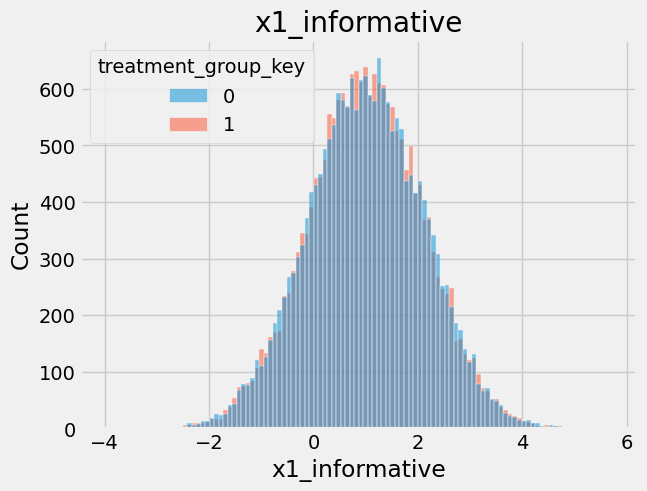

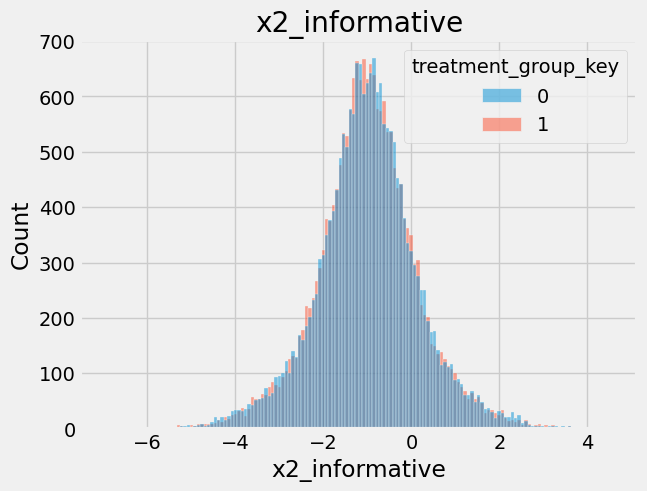

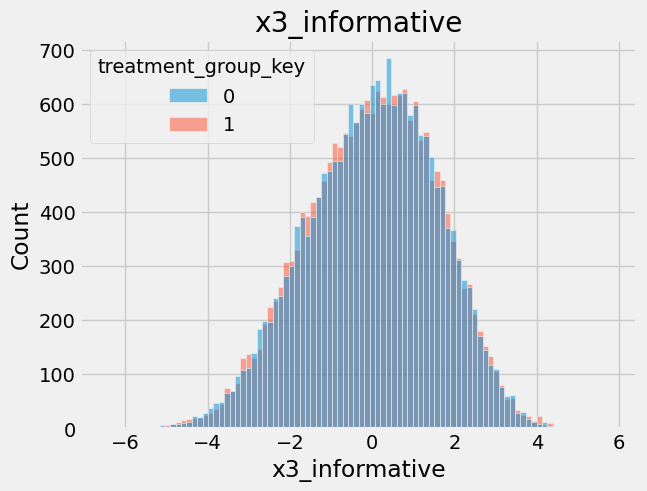

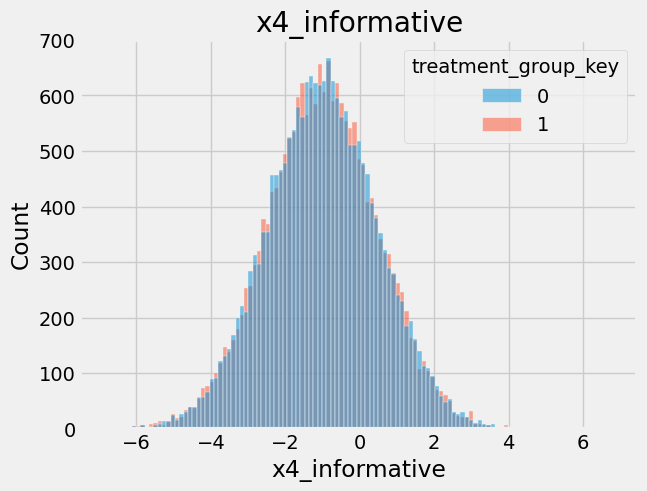

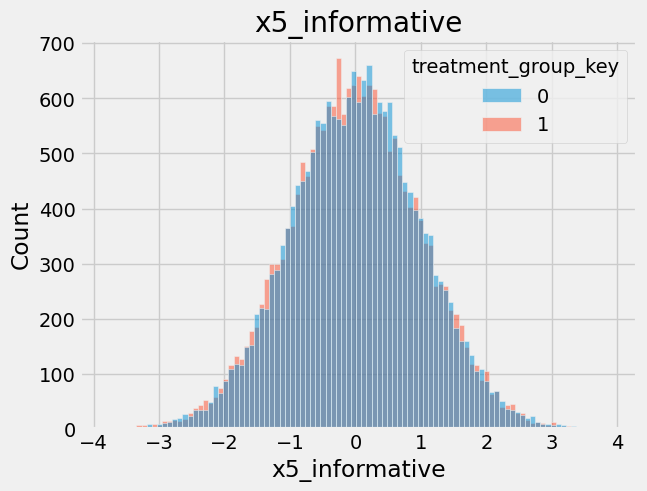

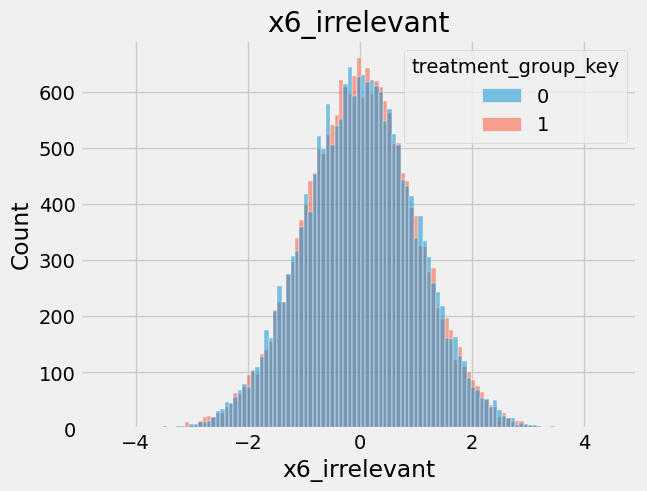

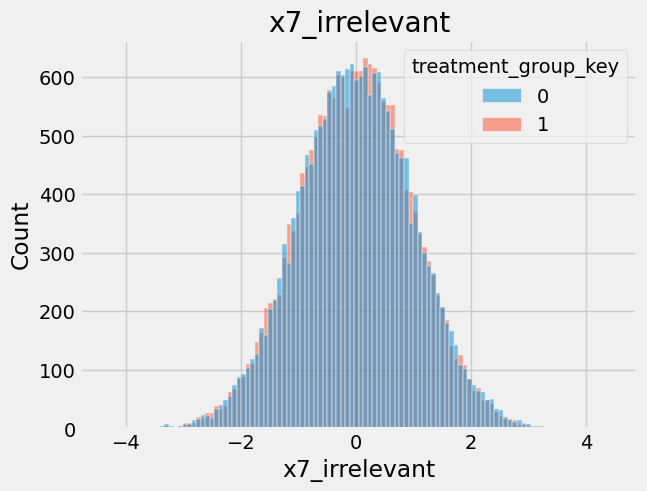

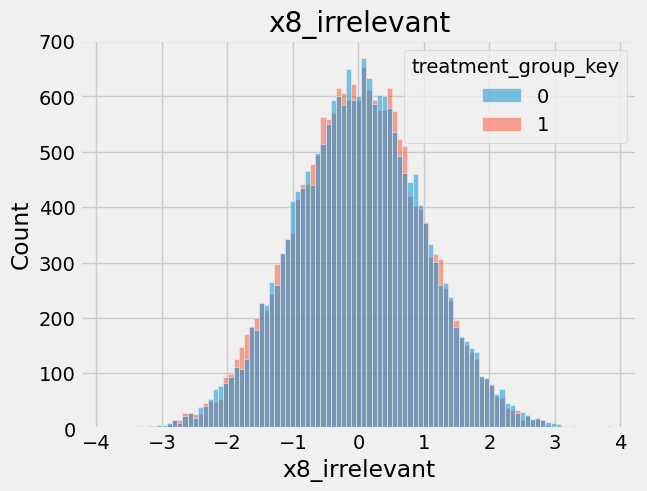

In [8]:
for col in x_names:
    sns.histplot(data = df, x=col, hue='treatment_group_key').set_title(col)
    plt.show()

Хотя таргет распределен довольно равномерно между контрольной и целевой группой, присутствует заметное расхождение средних для некоторых признаков. То есть попадание в контрольную и целевую группу может зависеть от характеристик объекта. <br><br> Давайте посмотрим, насколько различия между значениями признаков целевой и контрольной группы статистически значимы (полагаем уровень статзначимости 0.05, нулевая гипотеза - различий между группами нет, альтернативная - различия между группами есть), чтобы понять, насколько отличия существенны. <br><br> На практике статистическая разница между группами может присутствовать, так как целевая группа (кому направили коммуникацию) может формироваться по тем или иным бизнес-правилам.

In [9]:
df_1 = df.drop(columns = ['target'])
df_1.treatment_group_key = df_1.treatment_group_key.astype('str')
df_1.treatment_group_key = df_1.treatment_group_key.replace({'0':'control',
                                                             '1':'test'})
df_1 = df_1.rename(columns={'treatment_group_key':'group'})

In [10]:
for col in x_names:
    psi = calculate_psi(expected = df_1[df_1.group == 'control'][col],
                        actual = df_1[df_1.group == 'test'][col])
    print(f'psi для признака {col} равно {psi}')

psi для признака x1_informative равно 0.0006331753015234721
psi для признака x2_informative равно 0.0008113729973312233
psi для признака x3_informative равно 0.00044331352151926406
psi для признака x4_informative равно 0.00029127470983000354
psi для признака x5_informative равно 0.0008986661906084101
psi для признака x6_irrelevant равно 0.0004968434929879398
psi для признака x7_irrelevant равно 0.0005867663155941125
psi для признака x8_irrelevant равно 0.0011577547550994797


Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1)

Для категориальных переменных (в данном случае у нас их нет) и непрерывных переменных после бинаризации полезно посмотреть, насколько сильно отличается среднее значение таргета в контрольной и целевой группе в обучающей выборке. Давайте проделаем это. Фактически мы максимально грубо построим некоторый прообраз uplift-решающего дерева, про которое будет рассказано далее (то есть найдем признаки и те их значения, которые дают максимальный вклад в uplift по всей выборке и таким образом довольно грубо найдем пользователей, наиболее восприимчивых к коммуникации)

In [11]:
train_index, test_index = train_test_split(df.index, test_size=0.25, random_state=RANDOM_STATE)

In [12]:
column = 'x1_informative'

df_train = df.loc[train_index].copy()
df_train[column + '_bin'] = pd.qcut(df[column], q=6, duplicates='drop')


In [13]:
tmp = df_train.groupby(by=['x1_informative_bin','treatment_group_key']).agg({'target':'mean'}).reset_index()
tmp_1 = tmp[tmp['treatment_group_key']==1].drop(columns='treatment_group_key').set_index('x1_informative_bin')
tmp_0 = tmp[tmp['treatment_group_key']==0].drop(columns='treatment_group_key').set_index('x1_informative_bin')
best_uplift = tmp_1 - tmp_0
best_uplift

,target
x1_informative_bin,
"(-3.979, -0.0591]",-0.009691
"(-0.0591, 0.525]",0.011734
"(0.525, 1.004]",0.017737
"(1.004, 1.485]",0.013499
"(1.485, 2.085]",-0.018790
"(2.085, 5.718]",-0.023337


<h2>Обучение первой модели</h2>

Как решать задачу? В простейшем случае можно поступить следующим образом:

1. Обучим модель на X_train (с колонкой с флагом коммуникации)
2. Для построения предсказаний (predict_proba) uplift подадим X_test дважды - сначала указав в качестве флага коммуникации 0, а затем указав в качестве флага коммуникации 1

Этот подход называется Solomodel. 

In [14]:
X_train = df.loc[train_index].drop(columns = 'target')
y_train = df.loc[train_index].target
X_test = df.loc[test_index].drop(columns = 'target')
y_test = df.loc[test_index].target

In [15]:
model = LogisticRegression(random_state=RANDOM_STATE)

In [16]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [17]:
X_test_0 = X_test.copy()
X_test_0['treatment_group_key'] = 0
X_test_0.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant
32823,0,1.558881,-0.279099,-1.171773,-1.779082,-0.766971,-0.617859,0.986989,0.301869
16298,0,0.018831,-0.783363,0.707355,-2.846963,-1.769417,0.605445,0.173402,-0.151209
28505,0,2.033002,0.694059,-1.422458,-0.453822,2.276806,2.356658,1.019202,-0.509294
6689,0,1.085044,-0.584606,0.823661,-1.333769,-1.032043,-1.565472,-1.585665,0.210667
26893,0,1.058238,-1.143801,0.982797,-1.811322,-0.493691,0.167439,-1.337518,1.447407


In [18]:
y_pred_0 = model.predict_proba(X_test_0)[:,1]

In [19]:
X_test_1 = X_test.copy()
X_test_1['treatment_group_key'] = 1
X_test_1.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant
32823,1,1.558881,-0.279099,-1.171773,-1.779082,-0.766971,-0.617859,0.986989,0.301869
16298,1,0.018831,-0.783363,0.707355,-2.846963,-1.769417,0.605445,0.173402,-0.151209
28505,1,2.033002,0.694059,-1.422458,-0.453822,2.276806,2.356658,1.019202,-0.509294
6689,1,1.085044,-0.584606,0.823661,-1.333769,-1.032043,-1.565472,-1.585665,0.210667
26893,1,1.058238,-1.143801,0.982797,-1.811322,-0.493691,0.167439,-1.337518,1.447407


In [20]:
y_pred_1 = model.predict_proba(X_test_1)[:,1]

In [21]:
uplift = y_pred_1 - y_pred_0

In [22]:
uplift_pd = pd.DataFrame(data = uplift, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)

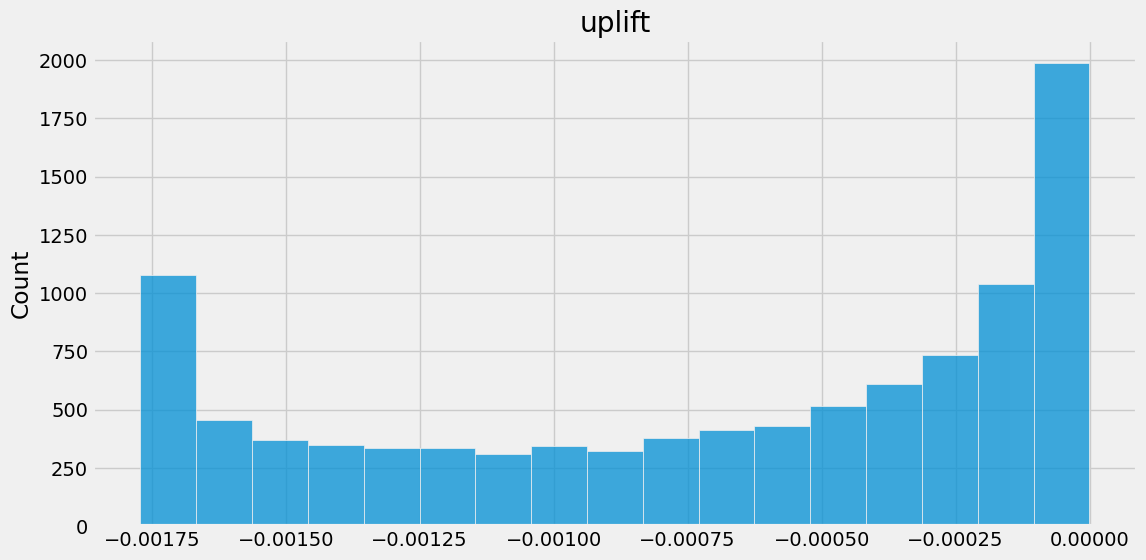

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = uplift_pd, x=uplift).set_title('uplift')
plt.show()

In [24]:
uplift_pd.head()

,uplift
16858,-2.708915e-07
8925,-3.130481e-07
2149,-4.129683e-07
16085,-4.442836e-07
12249,-6.023723e-07


In [25]:
uplift_pd.tail()

,uplift
25157,-0.001771
1430,-0.001771
23657,-0.001771
6231,-0.001771
36453,-0.001771


Мы построили первый прогноз uplift. Однако в данном ноутбуке мы не охватили целый ряд вопросов, а именно:
1. Преобразование данных для uplift. Перед обучением данные необходимо предобрабатывать (закрытие пропусков, скейлинг численные переменных и пр.), однако наличие флага коммуникации на обучении и его отсутствие на инференсе модели создает проблемы при использовании стандартных пайплайнов из Sklearn
2. Оценка качества модели Uplift
3. Обзор основных подходов к построению Uplift-моделей (Meta-learners, преобразование классов, Uplift-решающее дерево)
4. Калибровка моделей для Uplift
5. Отбор признаков и декомпозиция задачи

<h2>Источники</h2>

1. Библиотека Sklift. Основная идея — предоставить простую в использовании и быструю библиотеку для решения задач Uplift. Предоставляет интерфейс модели с привычным API scikit-learn. Разработана сотрудниками компании МТС.<br>
https://www.uplift-modeling.com/en/v0.5.1/user_guide/index.html
2. CausalML. Более продвинутая библиотека для Uplift-моделирования. Разработана компанией Uber <br>
https://causalml.readthedocs.io/en/latest/about.html 
3. PSI <br>https://github.com/mwburke/population-stability-index/tree/master